 David Íñiguez Gómez & Jaume Sánchez Salazar

**Practical 3 : Robust Linear Regression**

In [53]:
import numpy as np
import math
import matplotlib.pyplot as plt

# 1.- Introduction

## Some definitions before starting to work with the set of points

Definition of the least squares error function $Q(x,y,w)$, and its gradient $\nabla Q(x,y,w)$:


*   $Q(x,y,w) = \frac{1}{2} \sum_{i=1}^{m} (w_0x_i+w_1-y_i)^2 $
*   $\nabla Q(x,y,w) = \sum_{i=1}^{m} (w_0x_i+w_1-y_i)(x_i,1)$


In [54]:
def Q(x,y,w):
  n = len(x)
  aux = 0
  for i in range(n):
    aux+= (w[0]*x[i] + w[1] - y[i])*(w[0]*x[i] + w[1] - y[i])*(1/2)
  return(aux)

def gradQ(x,y,w):
  n = len(x)
  aux1 =  aux2 = 0
  for i in range(n):
    aux1 += (w[0]*x[i] + w[1] - y[i])*x[i]
    aux2 += w[0]*x[i] + w[1] - y[i]
  return(np.array([aux1,aux2]))


Computation of the gradient method, where the function we want to minimize is $Q(x,y,w)$

In [55]:
def gradient_method(x,y,w):
  Qx = []
  Qy = []
  tol = 10**(-3)
  Qx.append(w[0])#initial w0
  Qy.append(w[1]) #initial w1
  grad = gradQ(x,y,w)
  cont = 0
  while(np.linalg.norm(grad) >= tol):
      alpha = 1
      while (Q(x,y,[Qx[cont]-alpha*grad[0], Qy[cont]-alpha*grad[1]]) >= Q(x,y,[Qx[cont], Qy[cont]])):
        alpha/=2

      cont+= 1
      Qx.append(Qx[cont-1] - alpha*grad[0])
      Qy.append(Qy[cont-1] - alpha*grad[1])
      w = [Qx[cont],Qy[cont]]
      grad = gradQ(x,y,w)

  print("Number of iterations", cont)
  print("Last iteration: (%.2e,%.2e): " % (Qx[cont],Qy[cont]))
  return([Qx[cont],Qy[cont]])


## Exercise 1

Creation of the set of points that will be used among all the notebook.

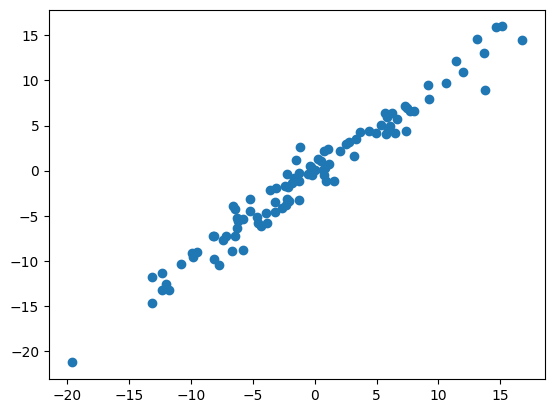

In [56]:
#Exercise 1
m = [0.,0.]
angle = 45*math.pi/180
rot = np.array([[math.cos(angle), -math.sin(angle)], [math.sin(angle),math.cos(angle)]])
lamb = np.array([[100,0],[0,1]])
s = np.matmul(rot, np.matmul(lamb, rot.transpose()))
points = np.random.multivariate_normal(m,s,100)
#print(points)
X =np.copy(points[:,0])
Y =np.copy(points[:,1])
plt.scatter(X,Y) #We will work with this set of points among all the project
plt.show()

Let us apply the gradient descent( with LSM as error measure ) to get the optimal parameters and plot the points and the linear regressor.


Number of iterations 230
Last iteration: (9.72e-01,-2.37e-01): 


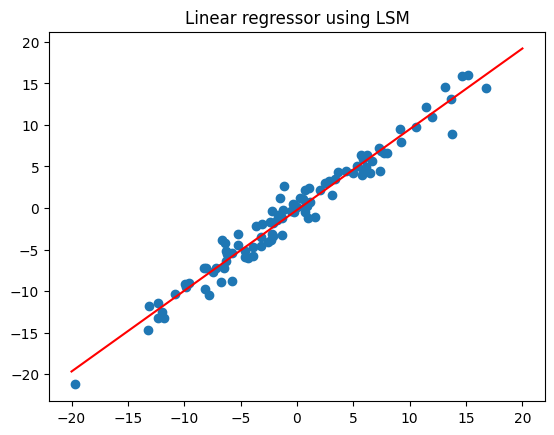

In [57]:
w = [np.random.rand(1), np.random.rand(1)]
w = gradient_method(X,Y,w)
z = np.linspace(-20,20,40)
y_hat= w[0]*z+w[1]
plt.scatter(X,Y)
plt.plot(z,y_hat,'r')
plt.title('Linear regressor using LSM')
plt.show()

Note that even though the points are generated with the function $y=x$ $(+ noise)$, the fit obtained is not exactly the generating function, that's because of the presence of noise. Despite that, it's a good aproximation.

## Exercise 1.2

Let's now add an outlier and see how the algorithm behaves.

Number of iterations 333
Last iteration: (6.30e-01,5.86e-02): 


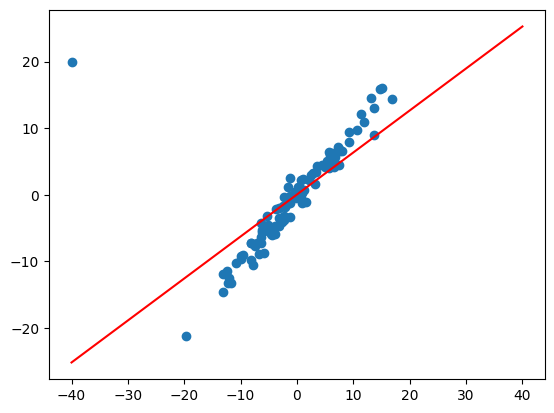

In [58]:
#Exercise 1.2
#Adding  an outlier
points[1]=[-40,20]
x = np.copy(points[:,0]) #dataset with one outlier
y = np.copy(points[:,1]) #dataset with one outlier
w = gradient_method(x,y,w)
z = np.linspace(-40,40,80)
y_hat= w[0]*z+w[1]
plt.scatter(x,y)
plt.plot(z,y_hat,'r')
plt.show()

We can see that the fit tends to get worse as well as the term of the outlier is the strongest one because the error function is quadratic. If we add more outliers we get the following:



Number of iterations 378
Last iteration: (2.37e-01,-5.47e-01): 


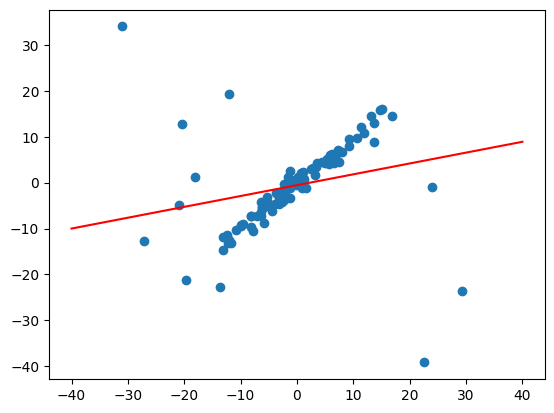

In [59]:
#Adding 10 outliers
for i in range(10):
  points[i] = (np.random.rand(2) - 0.5) * 80

x_10 = np.copy(points[:,0])
y_10 = np.copy(points[:,1])
w = gradient_method(x_10,y_10,w)
z= np.linspace(-40,40,80)
y_hat= w[0]*z+w[1]
plt.scatter(x_10,y_10)
plt.plot(z,y_hat,'r')

Notice that now, with 10 outliers,  the linear regressor is heavily influenced by all of them, which means that the algorithm take into account the outliers,  more than the other points

# 2.- Robust functions

As we did in exercise 1, we define first the functions that will be used in this excercise. We will now use the Cauchy function, that is :
$$
\rho(u) = \frac{c^2}{2} \text{ log } \Big[ 1+ \Big(\frac{u}{c} \Big)^2 \Big]
$$

So, now we have that:

$$Q_{cauchy} = \sum_{i=1}^m \rho(e_i) = \frac{c^2}{2}  \sum_{i=1}^m \text{ log } \Big[ 1 + \Big( \frac{\hat{y}_i - y_i}{c} \Big)^2 \Big]
$$

where $\hat{y}_i = w_0 x_i + w_1$.

In [60]:
def Q_cauchy(x,y,w,c=1):  #we assume c = 1
  n = len(x)
  aux = 0
  for i in range(n):
    aux+= np.log(1+  (((w[0]*x[i] + w[1] - y[i])/c)**2))
  return(((c**2)/2)*aux )

def gradQ_cauchy(x,y,w, c=1):
  n = len(x)
  aux1 = aux2 = 0
  for i in range(n):
    aux1 +=  ((1 +  ((w[0]*x[i] + w[1] - y[i])/c)**2)**(-1) )*((w[0]*x[i] + w[1] - y[i])/c)*(x[i]/c)
    aux2 += ((1 +  ((w[0]*x[i] + w[1] - y[i])/c)**2)**(-1) )*((w[0]*x[i] + w[1] - y[i])/c)*(1/c)

  aux1 = (c**2)*aux1
  aux2 = (c**2)*aux2
  return np.array([aux1,aux2])

def gradient_method_cauchy(x,y,w,c=1):
  Qx = []
  Qy = []
  tol = 10**(-5)
  #if(c<=0.01):
    #tol = 10**(-10)

  Qx.append(w[0]) #initial w0
  Qy.append(w[1]) #initial w1
  grad = gradQ_cauchy(x,y,w,c)
  cont = 0
  while(np.linalg.norm(grad) >= tol):
      alpha = 1
      while (Q_cauchy(x,y,[Qx[cont]-alpha*grad[0], Qy[cont]-alpha*grad[1]],c) >= Q_cauchy(x,y,[Qx[cont], Qy[cont]],c)):
        alpha/=2
        if(alpha <= 10**(-10)):
          break

      if(alpha <= 10**(-10)):
          break
      cont+= 1

      Qx.append(Qx[cont-1] - alpha*grad[0])
      Qy.append(Qy[cont-1] - alpha*grad[1])
      w = [Qx[cont],Qy[cont]]
      grad = gradQ_cauchy(x,y,w,c=1)


  print("Number of iterations", cont)
  print("Last iteration: (%.2e,%.2e): " % (Qx[cont],Qy[cont]))
  return([Qx[cont],Qy[cont]])

## Exercise 1

We plot the Cauchy and LSM to see the difference between both error measures

In [61]:
#Definitions of the functions we need
def lsf(u):
    return (1/2)*(u**2)

def cauchyf(u, c=1):
    return ((c**2)/2 )* (np.log(1 + (u/c)**2))

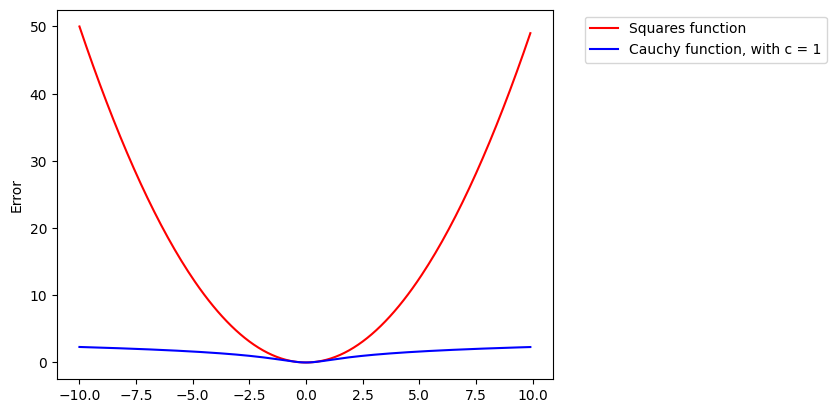

In [62]:
#Exercise 1
x1 = np.arange(-10,10,0.1)
y1 = lsf(x1)
y2 = cauchyf(x1)

plt.plot(x1,y1, 'red', label = 'Squares function')
plt.plot(x1,y2, 'blue', label = 'Cauchy function, with c = 1')
plt.ylabel("Error")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In this plot, we can observe clearly how the squares function is way more sensible to outliers. As well as the objective is minimizing the error, the algorithm will tend to minimize the error commited by the outliers, which are the most important points in LSM. In the case of Cauchy, the error difference between outliers and points near the fit is smaller, so the algorithm will not pay more attention to the them. That is why Cauchy is more robust, because is not more sensible to outliers.


## Exercise 2

Here we apply the gradient descent method to the starting set of points, but now using the Cauchy function

Number of iterations 261
Last iteration: (9.64e-01,-8.84e-02): 


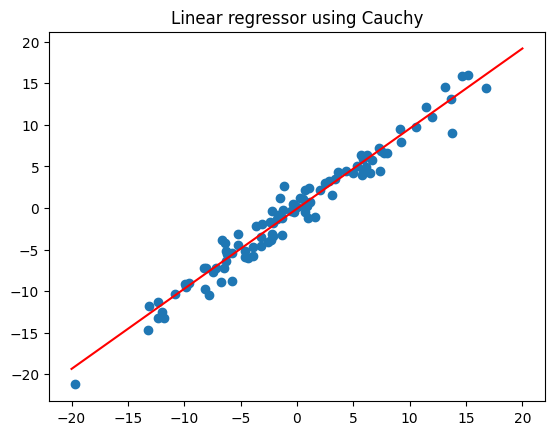

In [63]:
w = [np.random.rand(1), np.random.rand(1)]
w = gradient_method_cauchy(X,Y,w,c=1)
z = np.linspace(-20,20,40)
y_hat= w[0]*z+w[1]
plt.scatter(X,Y)
plt.plot(z,y_hat,'r')
plt.title('Linear regressor using Cauchy')
plt.show()

#Exercise 3


Let us compare both functions:

Number of iterations 229
Last iteration: (9.72e-01,-2.37e-01): 
Number of iterations 267
Last iteration: (9.64e-01,-8.84e-02): 


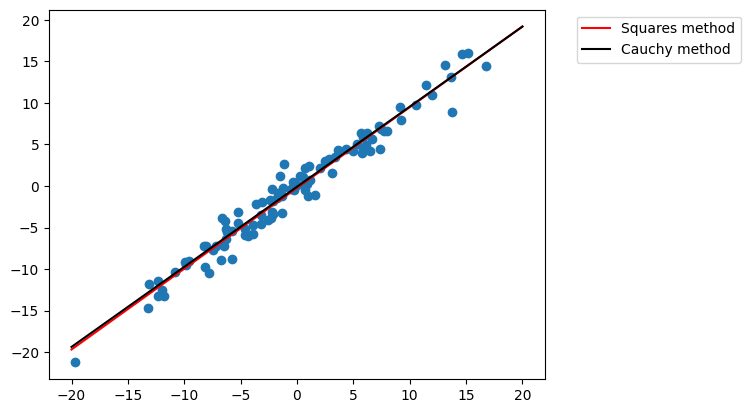

In [64]:
#Without outliers
w = [np.random.rand(1), np.random.rand(1)] #initial w
w_lsm = gradient_method(X,Y,w)
w_cauchy = gradient_method_cauchy(X,Y,w,c=1)
z = np.linspace(-20,20,40)
y_hat_lsm= w_lsm[0]*z+w_lsm[1]
y_hat_cauchy = w_cauchy[0]*z+w_cauchy[1]
plt.scatter(X,Y)
plt.plot(z,y_hat_lsm,'r', label = 'Squares method')
plt.plot(z,y_hat_cauchy, 'black', label = 'Cauchy method')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

As we can see in the plot, without outliers, both methods give  us really similar linear regressors. That is due to the very similar behaviour both measures have when points are close to the generating function. Let's consider cases with some outliers on the data samples.

#Exercise 4


Let us add, first, one outlier.

Number of iterations 367
Last iteration: (6.30e-01,5.86e-02): 
Number of iterations 266
Last iteration: (9.66e-01,-1.02e-01): 


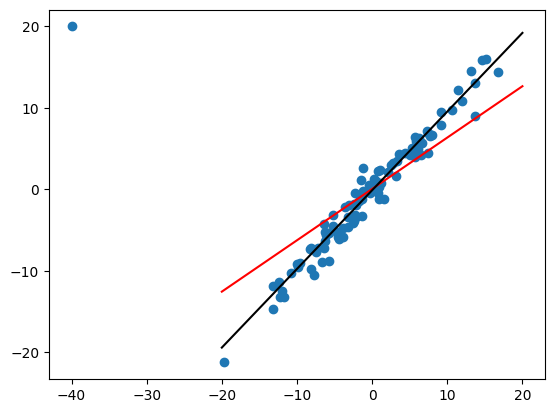

In [65]:
#Exercise 4.
#Recall that x,y are the datasets with one outlier
w = [np.random.rand(1), np.random.rand(1)] #initial w
w_lsm = gradient_method(x,y,w)
w_cauchy = gradient_method_cauchy(x,y,w,c=1)

z = np.linspace(-20,20,40)
y_hat_lsm= w_lsm[0]*z+w_lsm[1]
y_hat_cauchy = w_cauchy[0]*z+w_cauchy[1]
plt.scatter(x,y)
plt.plot(z,y_hat_lsm,'r')
plt.plot(z,y_hat_cauchy, 'black')
plt.show()
#plt.scatter(points[:,0],points[:,1])
#plt.plot(z,y_hat_cauchy, 'black')
#plt.show()

As one can see in the previous plot, and as commented before, LSM is much more sensitive to outliers than Cauchy.

## Exercise 5

Let us study now what happens when we change the $c$ value.

Number of iterations 222
Last iteration: (9.64e-01,-8.84e-02): 
The optimal parameters for c= 1 are: [0.9640919137518548, -0.08837013834128629] and we print it in color  red
Number of iterations 6
Last iteration: (9.69e-01,-2.97e-02): 
The optimal parameters for c= 100 are: [0.968923334553374, -0.02974609704692948] and we print it in color  green
Number of iterations 4
Last iteration: (9.60e-01,-3.81e-02): 
The optimal parameters for c= 0.01 are: [0.9595770738971028, -0.03814416190592592] and we print it in color  orange
Number of iterations 7
Last iteration: (9.27e-01,-4.04e-02): 
The optimal parameters for c= 0.001 are: [0.9265504880757517, -0.04037800151235844] and we print it in color  black


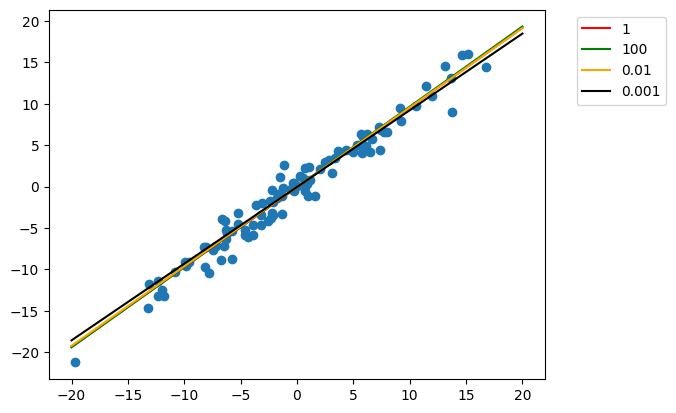

In [66]:
#Exercise 5
c = [1, 100, 1/100, 1/1000] #c values
colors = ['red', 'green', 'orange', 'black']
# w = [np.random.rand(1), np.random.rand(1)] #initial w
w = [0,0]
u_list = []

for i in range(4):
    w_cauchy=gradient_method_cauchy(X,Y,w,c=c[i])
    print("The optimal parameters for c=",c[i],"are:", w_cauchy, "and we print it in color ",colors[i])
    z = np.linspace(-20,20,40)
    y_hat= w_cauchy[0]*z+w_cauchy[1]
    plt.plot(z, y_hat, colors[i], label = c[i])
    u_list.append(abs(w_cauchy[0]*X+w_cauchy[1] - Y))


plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.scatter(X,Y)
plt.show()


We can see how both $c$ values present a similar behaviour.

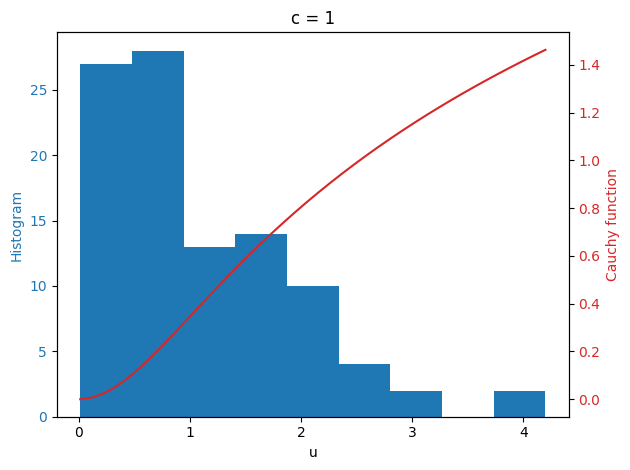

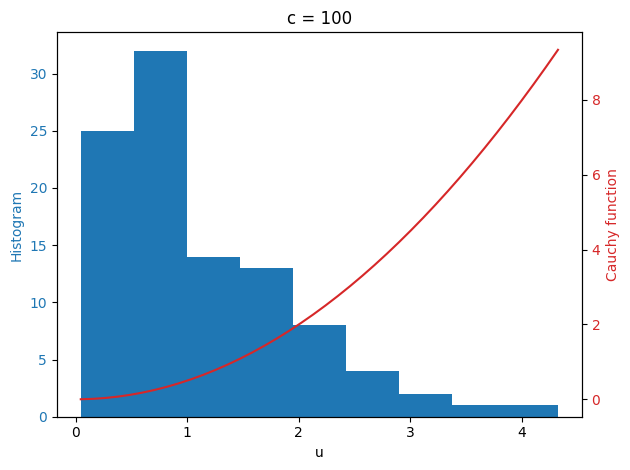

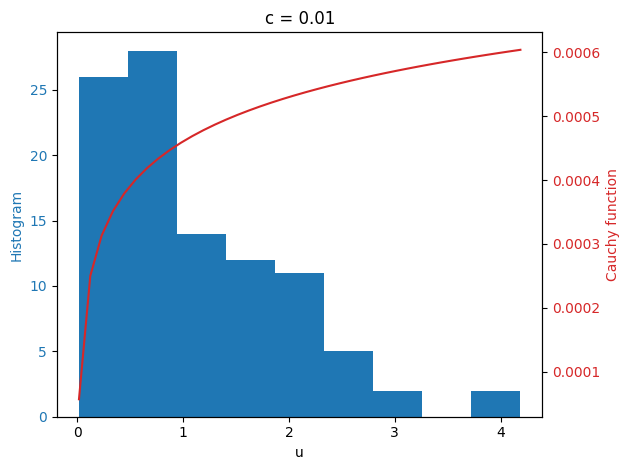

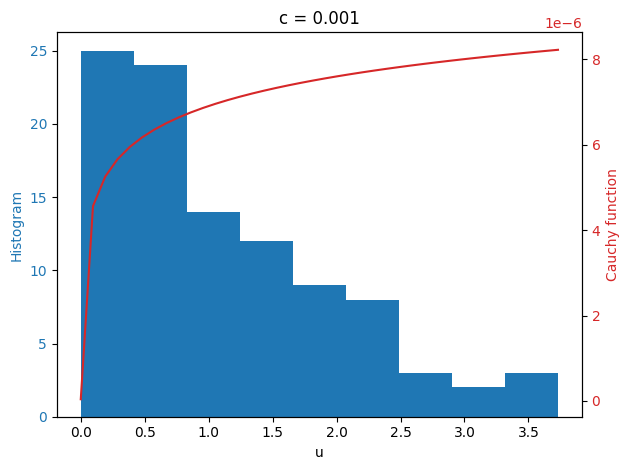

In [67]:
nbins = np.sqrt(len(X))
for i in range(4):
  #print (u_list[i])
  bins = np.linspace(min(u_list[i]),max(u_list[i]), int(nbins))
  domain = np.linspace(min(u_list[i]), max(u_list[i]),40)
  fig,ax1 = plt.subplots()
  color = 'tab:blue'
  ax1.set_title ('c = %s' %(c[i]))
  ax1.set_xlabel('u')
  ax1.set_ylabel('Histogram', color=color)
  ax1.hist (x=u_list[i],bins = bins, color = color)
  ax1.tick_params(axis='y', labelcolor=color)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:red'
  ax2.set_ylabel('Cauchy function', color=color)  # we already handled the x-label with ax1
  ax2.plot(domain, cauchyf(domain,c=c[i]), color=color)
  ax2.tick_params(axis='y', labelcolor=color)

  fig.tight_layout()
  plt.show()

As it can be seen in the plot of the Cauchy function, for small values of $c$, the parabolic behavior occurs for a smaller range of values, which implies that the standard deviation of that distribution is lower. This means that it is more restrictive when deciding whether a point is an outlier or not.


##Exercise 6

Let us gradually introduce more number of outliers into the dataset and study what happens using $c = 1$ and $c = 1/100$.

1
Number of iterations 252
Last iteration: (9.56e-01,-6.56e-02): 
0.01
Number of iterations 2
Last iteration: (9.21e-01,-6.97e-03): 


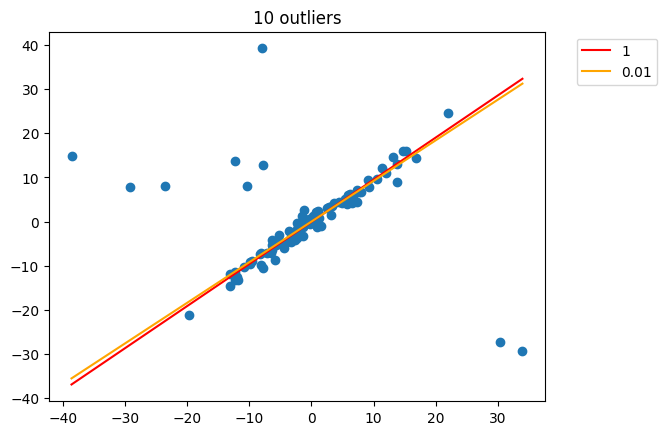

1
Number of iterations 231
Last iteration: (9.37e-01,-7.98e-02): 
0.01
Number of iterations 4
Last iteration: (9.30e-01,-6.59e-03): 


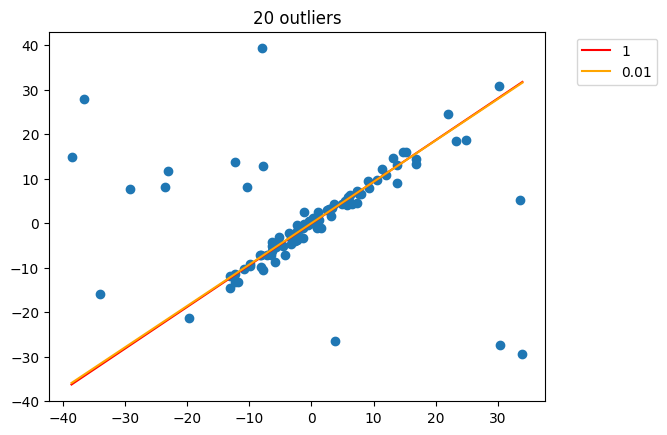

1
Number of iterations 161
Last iteration: (9.45e-01,-9.64e-02): 
0.01
Number of iterations 7
Last iteration: (9.19e-01,-2.98e-02): 


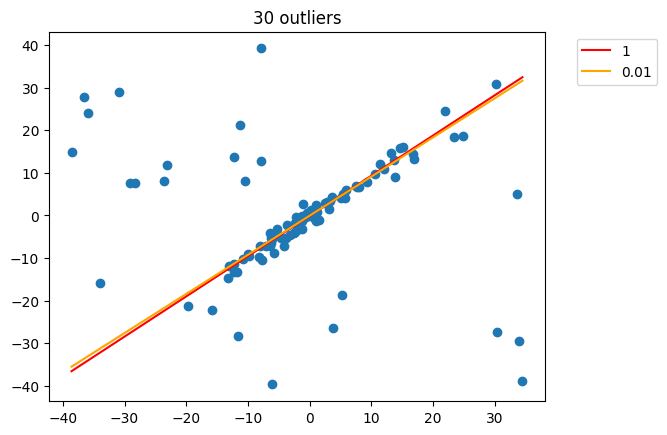

1
Number of iterations 132
Last iteration: (9.35e-01,-1.86e-01): 
0.01
Number of iterations 5
Last iteration: (9.21e-01,-5.47e-02): 


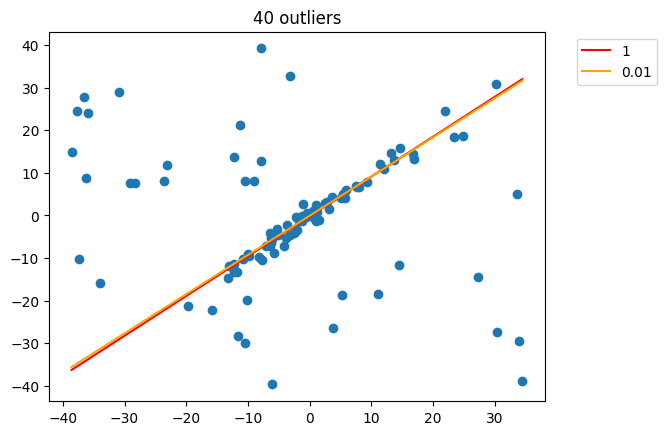

1
Number of iterations 171
Last iteration: (1.00e+00,-4.89e-01): 
0.01
Number of iterations 6
Last iteration: (9.90e-01,-1.59e-01): 


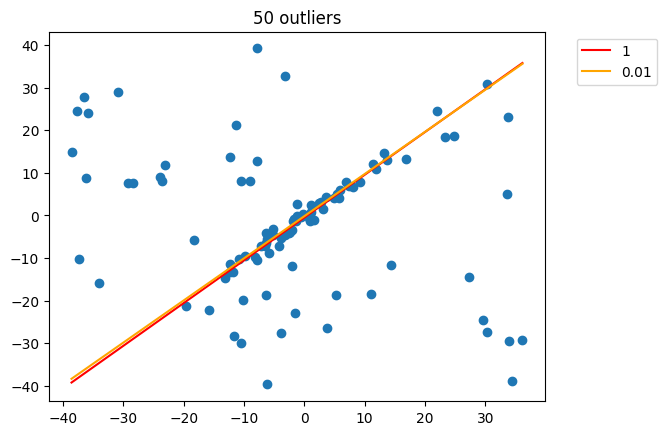

In [68]:
for i in range(50):
  points[i] = (np.random.rand(2) - 0.5) * 80

X_last = np.copy (X)
Y_last = np.copy (Y)

c_final = [1,1/100]
colors_final = ['red', 'orange']

for i in range (5):
  for j in range (10):
    X_last[10*i+j] = points[10*i+j,0]
    Y_last[10*i+j] = points[10*i+j,1]
  plt.scatter(X_last, Y_last)
  z = np.linspace(min(X_last),max(X_last),40)
  for j in range (2):
    print (c_final[j])
    w_cauchy=gradient_method_cauchy(X_last,Y_last,[0,0],c=c_final[j])
    y_hat= w_cauchy[0]*z+w_cauchy[1]
    plt.plot(z, y_hat, colors_final[j], label = c_final[j])
  plt.title ('%d outliers' % (10*(i+1)))
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
  plt.show()

As we saw in the histogram plots, for $c = 0.01$ the range of values where the quadratic approximation is valid is much smaller, and once that range is exceeded the behavior is almost constant. This is much more robust against outliers than if $c = 1$, since this presents a parabolic behavior for a greater range of values.